In [1]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd

from popy.io_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.plotting_tools import *

import popy.config as cfg

def get_epoch_lens(neural_data):
    ids = neural_data[:, neural_data.trial_id == neural_data.trial_id[0]].epoch_id
    ep_lens = [0]
    for id in np.unique(ids):
        ep_lens.append(np.count_nonzero(ids==id)/100)
    ep_times = np.cumsum(ep_lens)

    # label epochs
    labels = ['st', 'Lt', 'Lv', 'Tt', 'Tv', 'fb', 'fin']
    ep_times = {labels[i]: ep_times[i] for i in range(len(labels))}

    return ep_times

Using HOME path
Inserm drive is not accessible


/var/folders/sc/1kct8wp55hz13v5hhnxrrfy40000gn/T/ipykernel_8754/1004072520.py:14: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  win = scs.gaussian(int(12 * .05 / bin_size), .05 / bin_size)


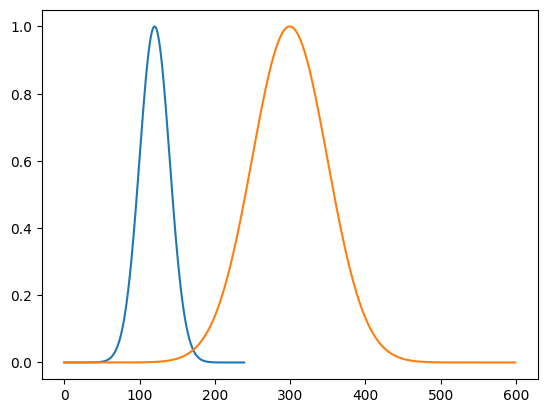

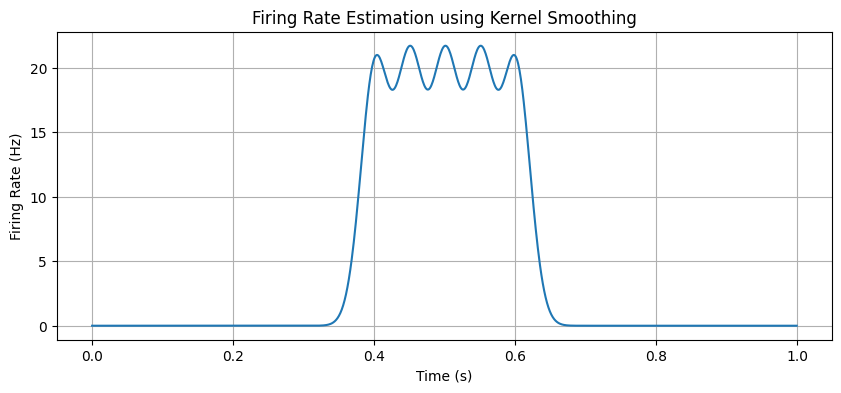

In [2]:
import numpy as np
import scipy.signal

def spike_train_to_firing_rate_kernel(spike_train, kernel_width, sampling_rate):
    # Create a time vector corresponding to the spike train
    time = np.arange(len(spike_train)) / sampling_rate

    # Create the kernel (e.g., Gaussian kernel)
    kernel_duration = 6 * kernel_width  # Adjust the multiplier as needed
    kernel_time = np.arange(-kernel_duration, kernel_duration, 1 / sampling_rate)
    kernel = np.exp(-0.5 * (kernel_time / kernel_width) ** 2)

    bin_size = 1 / sampling_rate
    win = scs.gaussian(int(12 * .05 / bin_size), .05 / bin_size)
    #win = win / np.sum(win)
    plt.plot(kernel)
    plt.plot(win)

    # Convolve the spike train with the kernel to estimate firing rate
    firing_rate = scipy.signal.convolve(spike_train, kernel, mode='same', method='direct')

    # Normalize by the area under the kernel (integral of the kernel)
    firing_rate /= np.trapz(kernel, dx=1 / sampling_rate)

    return firing_rate

# Example usage:
# Define your spike train, kernel width, and sampling rate
spike_train = np.zeros(1000)
spike_train[400] = 1
spike_train[450] = 1
spike_train[500] = 1
spike_train[550] = 1
spike_train[600] = 1
kernel_width = 0.02  # Adjust as needed
sampling_rate = 1000  # Hz

# Convert spike train to firing rate using kernel smoothing
firing_rate = spike_train_to_firing_rate_kernel(spike_train, kernel_width, sampling_rate)

# Plot the firing rate
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(firing_rate)) / sampling_rate, firing_rate)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rate Estimation using Kernel Smoothing')
plt.grid(True)
plt.show()


In [3]:
monkey, session = 'ka', '210322'

# Load neural data
out_path = os.path.join(cfg.PROJECT_PATH_LOCAL, 'data', 'processed', 'rates')
floc = os.path.join(out_path, f'neural_data_{monkey}_{session}.nc')

neural_data = get_neural_data(monkey, session, 'rates', sr=100)

# remove trunctuated units
neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)

# remove low_firing units
neural_data = remove_low_fr_neurons(neural_data, 1)

# z-score neural data
#neural_data = scale_neural_data(neural_data)

# normalize neural data in time
neural_data = time_normalize_session(neural_data)

if False:
    neural_data.to_netcdf(floc)

Removed 12 units with truncated data.
Removed 0 units with mean firing rate below 1 Hz.
Normalizing firing rates (in time)...


100%|██████████| 425/425 [00:05<00:00, 79.42it/s]


In [4]:
neural_data

<xarray.DataArray (unit: 35, time: 318750)>
array([[2.5251055e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.6443475e-02, 7.8270453e-01, 3.2465246e-01, ..., 1.0965341e+00,
        8.7072688e-01, 6.6530341e-01],
       [0.0000000e+00, 7.8702235e-01, 0.0000000e+00, ..., 1.3019483e+00,
        1.6584830e+00, 2.0491920e+00],
       ...,
       [9.3075168e-01, 1.2307224e+00, 4.3819305e-01, ..., 8.2914084e-03,
        1.5144532e-02, 2.6619365e-02],
       [1.0647662e-03, 0.0000000e+00, 9.4135463e-01, ..., 5.4607445e-01,
        4.2955735e-01, 3.2465246e-01],
       [1.5494738e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.1135679e-06,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
  * unit              (unit) <U10 'MCC_06_01' 'MCC_07_01' ... 'LPFC_13_01'
    unit_id_original  (unit) int64 26 28 66 33 32 30 35 ... 64 38 72 73 54 50 75
    channel           (unit) int64 6 7 7 8 8 8 9 10 11 ... 8 8 9 10 11 12 12 13
    area              (unit) <U4 'MCC' 'MCC' 'MCC' ... 'LPFC' 'LPFC' 'LPFC'
    trial_id          (time) float64 0.0 0.0 0.0 0.0 ... 424.0 424.0 424.0 424.0
    epoch_id          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
  * time              (time) float64 9.8 10.23 10.65 ... 3.279e+03 3.279e+03
Attributes:
    bin_size:  0.01

Text(0.5, 0, 'Time (s)')

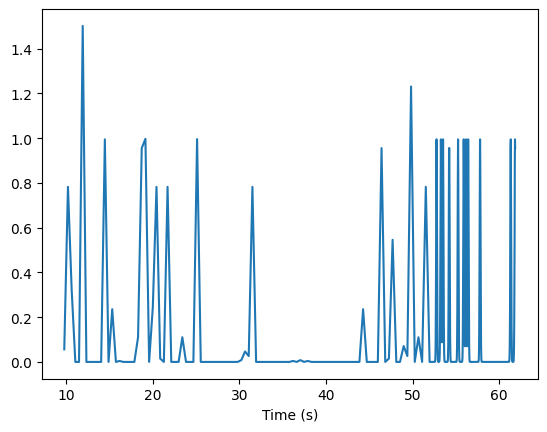

In [5]:
time = neural_data.time
data = neural_data[1]
plt.plot(time[:1000], data[:1000])
plt.xlabel('Time (s)')

In [6]:
import matplotlib.colors as mcolors

def plot_trajectory_fb_value(X, y, ep_times, label_name=None, ax=None, title=None, savedir=None):
    # colors from matplotlib tab
    colors = {label: color for label, color in zip(np.unique(y), list(mcolors.TABLEAU_COLORS.keys()))}
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    if title:
        ax.set_title(title)
        
    for i, y_curr in enumerate(np.unique(y)):
        data = X[y==y_curr]  # get data for current label

        # mean and std
        mean = data.mean(axis=0)
        std = data.std(axis=0)

        # plot mean trajectory with std
        ax.plot(mean, label=y_curr, color=colors[y_curr])
        ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=.2, color=colors[y_curr])

    # plot epoch times and label x axis
    for label, time in ep_times.items():
        ax.axvline(time, color='grey' if label != 'fb' else 'tab:red', linestyle='dashed', alpha=.5, linewidth=1)
    times_ticks = list(ep_times.values())[:-1]
    labels_ticks = list(ep_times.keys())[:-1]
    ax.set_xticks(times_ticks)
    ax.set_xticklabels(labels_ticks)

    ax.axhline(0, color='grey', alpha=0.5)  # plot zero line
    ax.set_xlabel('time')
    ax.set_ylabel('activity')

    # legend next to figure
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=label_name if label_name else None)

    if savedir:
        plt.savefig(savedir, bbox_inches='tight')



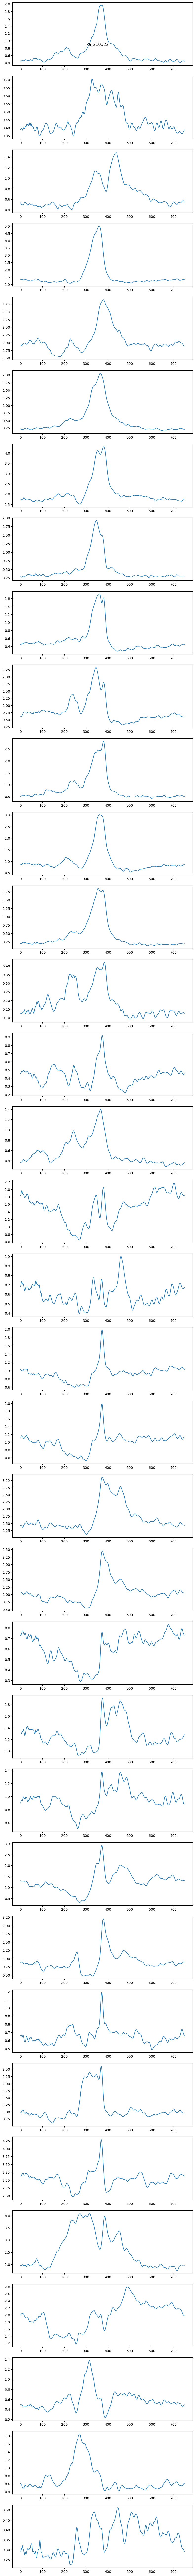

In [8]:
all_trials = np.unique(neural_data.trial_id.data)
y_1 = np.zeros(len(all_trials))

ep_times = get_epoch_lens(neural_data)
ep_times = {k: v/neural_data.attrs['bin_size'] for k, v in ep_times.items()}

n_pcs = neural_data.shape[0]

fig, axs = plt.subplots(n_pcs, 1, figsize=(8, 3*n_pcs))
plt.suptitle(f'{monkey}_{session}')

for pc, ax in enumerate(axs):
    # get data for pc
    unit_data = neural_data[pc, :]
    # create dataset of shape (n_trials, time_in_trial, n_components) from neural data format of shape (n_components, absoulte_time)
    unit_data_np = np.array([unit_data[np.where(unit_data.trial_id.data == trial)[0]] for trial in all_trials])
    
    """plot_trajectory_fb_value(unit_data_np, y_1, label_name='feedback', ep_times=ep_times, ax=ax,
                             title=f'PC {pc+1}')"""
    ax.plot(unit_data_np.mean(axis=0), label=f'PC {pc+1}')
    
plt.tight_layout()